<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210921_%E6%8F%90%E5%87%BA%E7%94%A8%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E4%BD%9C%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data', 'notebook', 'C0002_21_09_2021.csv']

In [3]:
DIR_DATA_TRAIN = os.path.join(DIR, 'data', 'Train_Unit_20210903')
DIR_DATA_TEST = os.path.join(DIR, 'data', 'Test_Unit_20210903')

In [4]:
#一連のデータ処理
def get_some_values(file_path):
  #ファイルパスから、ユニット名を取得。
  dirname = os.path.dirname(file_path)
  dirname_split = dirname.split('/')#区切り文字'/'で分割
  unit = dirname_split[-2]
  charge_mode = dirname_split[-1]
  #ファイルパスから、サイクル数を取得。
  basename = os.path.basename(file_path)
  basename_split = basename.split('_')[4]#区切り文字'_'で分割
  cycle_num = basename_split.split('.')[0]
  return unit, charge_mode, cycle_num

#%time
#DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
#C = 'Discharge'

def data_reading(DATA_DIR, C):

  #カラム名変更前後の辞書
  col_list = {'Time (s)' : 'Time',
              'Voltage Measured (V)' : 'VM',
              'Voltage Charge (V)' : 'VC',
              'Current Measured (Amps)' : 'CM', 
              'Current Charge (Amps)' : 'CC',
              'Temperature (degree C)': 'Temp', 
              'unit' : 'unit_name', 
              'charge_mode' : 'mode', 
              'Cycle_num' : 'Cycle',
              'Voltage Load (V)' : 'VL',
              'Current Load (Amps)' : 'CL'
  }

  df_list = []
  for folder in tqdm(os.listdir(DATA_DIR)[:3]):
    files = glob.glob(os.path.join(DATA_DIR, folder, C, '*.csv'))
    df_list_0 = []
    for file in files:
      tmp_df = pd.read_csv(file, encoding='utf-8')
      tmp_df = tmp_df.rename(columns=col_list)
      #ユニット名、充・放電モード、サイクル数の取得
      unit, charge_mode, cycle_num = get_some_values(file)
      #特徴量のデータフレームの作成
      if C == 'Charge':
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_c_vm' : featured_c_vm(tmp_df),
                          'feature_c_cm' : featured_c_cm(tmp_df),
                          'feature_c_vc' : featured_c_vc(tmp_df)}])
      else:
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_d_vm' : featured_d_vm(tmp_df),
                          'feature_d_vl' : featured_d_vl(tmp_df)}])
      df_list_0.append(df_exp)
    df_0 = pd.concat(df_list_0)
    df_list.append(df_0)
  df = pd.concat(df_list)

  #ユニットとサイクルでソート。
  df = df.sort_values(['unit', 'Cycle_num'])
  #インデックスの振り直し
  df = df.reset_index(drop=True)

  return df

def featured_c_vm(df):
  #LAG=5が0.001未満が続くところを、飽和領域とみなす。
  p_c_vm = df.loc[:, 'VM'][df.loc[:, 'VM'].diff(5) < 0.001]
  #飽和領域のなかで、最初の点を点P_C_VMとする。
  p_c_vm = p_c_vm.reset_index(inplace=False)
  p_c_vm = p_c_vm['index'].iloc[0]
  #充電VMの特徴量は、点P_C_VMにおける時間
  feature_c_vm = df['Time'].loc[p_c_vm]
  return feature_c_vm

def featured_c_cm(df):
  #飽和領域からの立ち下がり点(LAG=5の勾配が最小となる点)を点P_C_CMとする。
  p_c_cm = np.gradient(df.loc[:, 'CM'].diff(5)[10:]).argmin()
  #充電CMの特徴量は、点P_C_CMにおける時間
  feature_c_cm = df['Time'].loc[p_c_cm]
  return feature_c_cm

def featured_c_vc(df):
  #VCが最大値を示す点を、点P_C_VCとする。
  p_c_vc = df.VC.argmax()
  #充電VCの特徴量は、点P_C_VCにおける時間
  feature_c_vc = df['Time'].loc[p_c_vc]
  return feature_c_vc

def featured_d_vm(df):
  #VMが最小値を示す点を、点P_D_VMとする。
  p_d_vm = df.VM.argmin()
  #放電VMの特徴量は、点P_D_VMにおける時間
  feature_d_vm = df['Time'].loc[p_d_vm]
  return feature_d_vm

def featured_d_vl(df):
  #VLの最大値点以降の領域において、最小値を示す点を、点P_D_VLとする。
  VL_max = df.VL.argmax()
  p_d_vl = df.VL[VL_max: ].argmin()
  #放電VLの特徴量は、点P_D_VLにおける時間
  feature_d_vl = df['Time'].loc[p_d_vl]
  return feature_d_vl

In [5]:
%time
#データの読み込み(学習)
#充電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_train_charge = data_reading(DATA_DIR, C)

#データの読み込み(学習)
#放電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_train_discharge = data_reading(DATA_DIR, C)

#充電と放電の特徴量のデータセット作成
df_train_feature = pd.merge(df_train_charge, df_train_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])

#データの読み込み(学習)
#充電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_test_charge = data_reading(DATA_DIR, C)

#データの読み込み(学習)
#放電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_test_discharge = data_reading(DATA_DIR, C)

#充電と放電の特徴量のデータセット作成
df_test_feature = pd.merge(df_test_charge, df_test_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


100%|██████████| 3/3 [00:28<00:00,  9.63s/it]


モデリング

In [6]:
num_train_unit_1 = 124
num_train_unit_2 = 40
num_train_unit_3 = 97

num_test_unit_1 = 70
num_test_unit_2 = 12
num_test_unit_3 = 55

In [7]:
from sklearn.linear_model import LinearRegression as LR

テストユニット1

In [8]:
#学習データとテストデータ
train_unit_1 = df_train_feature[df_train_feature['unit'] == 'Train_Unit_1' ].reset_index()
test_unit_1 = df_test_feature[df_test_feature['unit'] == 'Test_Unit_1' ].reset_index()

In [9]:
train_X = train_unit_1[:num_test_unit_1]['feature_d_vm'].values
train_y = test_unit_1[:num_test_unit_1]['feature_d_vm'].values

In [10]:
train_X = np.reshape(train_X, (-1, 1))
train_y = np.reshape(train_y, (-1, 1))

In [11]:
model_lr = LR()
model_lr.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

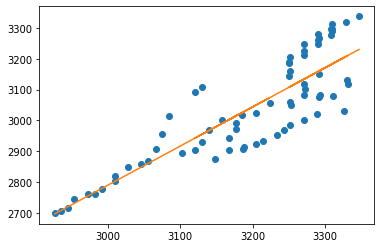

In [12]:
fig, ax = plt.subplots()

ax.plot(train_X, train_y, 'o')
ax.plot(train_X, model_lr.predict(train_X), linestyle="solid")

plt.show()

In [13]:
print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(train_X, train_y))

モデル関数の回帰変数 w1: 1.271
モデル関数の切片 w2: -1022.966
y= 1.271x + -1022.966
決定係数 R^2：  0.7460659839610881


In [14]:
test_X = train_unit_1[num_test_unit_1:]['feature_d_vm'].values
test_X = np.reshape(test_X, (-1, 1))
#test_X

In [15]:
#テストデータの予測
pred_test = model_lr.predict(test_X)
#pred_test

In [16]:
test_unit_1_70 = train_y
test_unit_1_pred = pred_test

In [17]:
test_unit_1 = np.concatenate([test_unit_1_70, test_unit_1_pred])
#test_unit_1

In [18]:
#ゴール(学習ユニットの故障時の到達点)
train_unit_1_min = np.min(train_unit_1['feature_d_vm'].values)
train_unit_1_min

2520.9

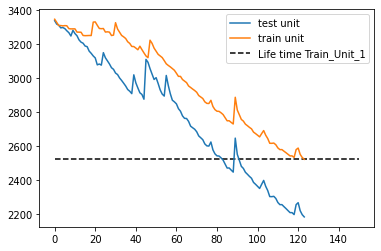

In [19]:
fig, ax = plt.subplots()

ax.plot(test_unit_1, label='test unit')
ax.plot(train_unit_1['feature_d_vm'], label='train unit')

plt.hlines(train_unit_1_min, 0, 150, linestyles='--', label='Life time Train_Unit_1')

plt.legend()
plt.show()

In [20]:
#テストユニットのデータセットを眺める
df_test_unit_1 = pd.DataFrame(test_unit_1, columns=['feature_d_vm'])
df_test_unit_1['Cycle'] = df_test_unit_1.index + 1
df_test_unit_1

,feature_d_vm,Cycle
0,3338.400000,1
1,3318.300000,2
2,3312.400000,3
3,3296.100000,4
4,3298.100000,5
...,...,...
119,2253.271161,120
120,2264.836295,121
121,2217.431953,122
122,2194.047505,123


In [21]:
search_step = 5
search_min = train_unit_1_min - search_step
search_max = search_step + train_unit_1_min

In [22]:
lifetime_test_1 = df_test_unit_1.query('@search_min <= feature_d_vm <= @search_max')
lifetime_test_1 = lifetime_test_1['Cycle']
lifetime_test_1

83    84
Name: Cycle, dtype: int64

テストユニット2

テストユニット2：訓練ユニット2と似ている。 feature_c_vm と feature_d_vm or feature_d_vlで、ほぼ説明できそう。　

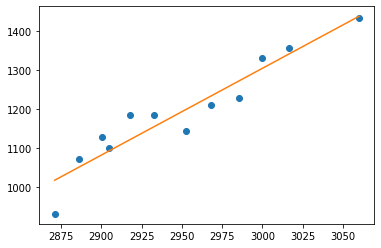

モデル関数の回帰変数 w1: 2.229
モデル関数の切片 w2: -5381.227
y= 2.229x + -5381.227
決定係数 R^2：  0.8938124977663215


In [23]:
#学習データとテストデータ
train_unit_2 = df_train_feature[df_train_feature['unit'] == 'Train_Unit_2' ].reset_index()
test_unit_2 = df_test_feature[df_test_feature['unit'] == 'Test_Unit_2' ].reset_index()

train_X = train_unit_2[:num_test_unit_2]['feature_d_vm'].values
train_y = test_unit_2[:num_test_unit_2]['feature_c_vm'].values

train_X = np.reshape(train_X, (-1, 1))
train_y = np.reshape(train_y, (-1, 1))

model_lr = LR()
model_lr.fit(train_X, train_y)

fig, ax = plt.subplots()

ax.plot(train_X, train_y, 'o')
ax.plot(train_X, model_lr.predict(train_X), linestyle="solid")

plt.show()

print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(train_X, train_y))

In [24]:
test_X = train_unit_2[num_test_unit_2:]['feature_d_vm'].values
test_X = np.reshape(test_X, (-1, 1))
#test_X

#テストデータの予測
pred_test = model_lr.predict(test_X)
#pred_test

test_unit_2_12 = train_y
test_unit_2_pred = pred_test

test_unit_2 = np.concatenate([test_unit_2_12, test_unit_2_pred])
#test_unit_2

In [25]:
#ゴール(学習ユニットの故障時の到達点)
train_unit_2_min = np.min(train_unit_2['feature_c_vm'].values)
#回帰式で変換
#train_unit_2_min = train_unit_2_min * model_lr.coef_ + model_lr.intercept_
print('学習ユニットの故障時：', train_unit_2_min)

学習ユニットの故障時： 795.98


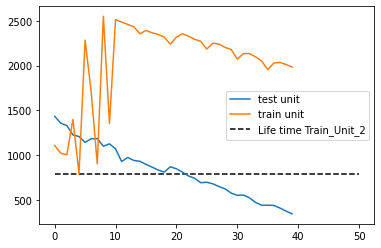

In [26]:
fig, ax = plt.subplots()

ax.plot(test_unit_2, label='test unit')
ax.plot(train_unit_2['feature_c_vm'], label='train unit')

plt.hlines(train_unit_2_min, 0, 50, linestyles='--', label='Life time Train_Unit_2')

plt.legend()
plt.show()

In [27]:
#テストユニットのデータセットを眺める
df_test_unit_2 = pd.DataFrame(test_unit_2, columns=['feature_c_vm'])
df_test_unit_2['Cycle'] = df_test_unit_2.index + 1
#df_test_unit_2

In [28]:
search_step = 17
search_min = train_unit_2_min - search_step
search_max = search_step + train_unit_2_min
lifetime_test_2 = df_test_unit_2.query('@search_min <= feature_c_vm <= @search_max')
lifetime_test_2 = lifetime_test_2['Cycle']
lifetime_test_2

21    22
Name: Cycle, dtype: int64

テストユニット3

テストユニット3：訓練ユニット1と似ている。 feature_d_vm feature_d_vl と feature_d_vm feature_d_vlで、ほぼ説明できそう。　

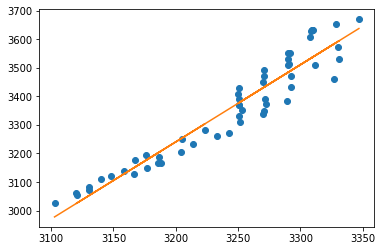

モデル関数の回帰変数 w1: 2.702
モデル関数の切片 w2: -5404.272
y= 2.702x + -5404.272
決定係数 R^2：  0.9110594062583919


In [29]:
#学習データとテストデータ
train_unit_3 = df_train_feature[df_train_feature['unit'] == 'Train_Unit_1' ].reset_index()
test_unit_3 = df_test_feature[df_test_feature['unit'] == 'Test_Unit_3' ].reset_index()

train_X = train_unit_3[:num_test_unit_3]['feature_d_vm'].values
train_y = test_unit_3[:num_test_unit_3]['feature_d_vm'].values

train_X = np.reshape(train_X, (-1, 1))
train_y = np.reshape(train_y, (-1, 1))

model_lr = LR()
model_lr.fit(train_X, train_y)

fig, ax = plt.subplots()

ax.plot(train_X, train_y, 'o')
ax.plot(train_X, model_lr.predict(train_X), linestyle="solid")

plt.show()

print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(train_X, train_y))

In [30]:
test_X = train_unit_3[num_test_unit_3:]['feature_d_vm'].values
test_X = np.reshape(test_X, (-1, 1))
#test_X

#テストデータの予測
pred_test = model_lr.predict(test_X)
#pred_test

test_unit_3_55 = train_y
test_unit_3_pred = pred_test

test_unit_3 = np.concatenate([test_unit_3_55, test_unit_3_pred])
#test_unit_3

In [31]:
#ゴール(学習ユニットの故障時の到達点)
train_unit_3_min = np.min(train_unit_3['feature_d_vm'].values)
print('学習ユニットの故障時：', train_unit_3_min)

学習ユニットの故障時： 2520.9


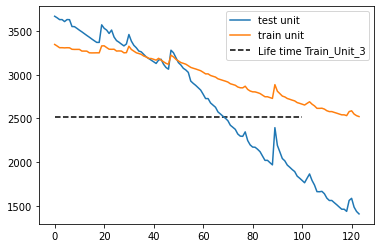

In [32]:
fig, ax = plt.subplots()

ax.plot(test_unit_3, label='test unit')
ax.plot(train_unit_3['feature_d_vm'], label='train unit')

plt.hlines(train_unit_3_min, 0, 100, linestyles='--', label='Life time Train_Unit_3')

plt.legend()
plt.show()

In [33]:
#テストユニットのデータセットを眺める
df_test_unit_3 = pd.DataFrame(test_unit_3, columns=['feature_d_vm'])
df_test_unit_3['Cycle'] = df_test_unit_3.index + 1
#df_test_unit_3

In [34]:
search_step = 10
search_min = train_unit_3_min - search_step
search_max = search_step + train_unit_3_min
lifetime_test_3 = df_test_unit_3.query('@search_min <= feature_d_vm <= @search_max')
lifetime_test_3 = lifetime_test_3['Cycle']
lifetime_test_3

68    69
Name: Cycle, dtype: int64

# 提出用ファイル作成

In [54]:
#残寿命の算出
RUL_unit_1 = (lifetime_test_1 - num_test_unit_1).values
RUL_unit_2 = (lifetime_test_2 - num_test_unit_2).values
RUL_unit_3 = (lifetime_test_3 - num_test_unit_3).values

In [55]:
type(RUL_unit_1)

numpy.ndarray

In [56]:
#提出ファイルの読み込み
file_submit = pd.read_csv(os.path.join(DIR, 'data', 'ISID_08_09_2021.csv'))

In [57]:
file_submit.columns

Index(['Unit 1 RUL', 'Unit 2 RUL', 'Unit 3 RUL'], dtype='object')

In [62]:
pd.DataFrame({
    file_submit.columns[0]:RUL_unit_1,
    file_submit.columns[1]:RUL_unit_2,
    file_submit.columns[2]:RUL_unit_3,
}).to_csv(os.path.join(DIR, "C0002_21_09_2021.csv"), index=False)